In [1]:
import sys
print(f"Environment: {sys.executable}")

Environment: /n/groups/datta/tim_sainburg/conda_envs/mmdeploy/bin/python3


In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
model_directory = Path("/n/groups/datta/tim_sainburg/datasets/scratch/mm_training/rtmpose/rtmpose-m_8xb64-210e_ap10k-256x256_24-08-15-10-58-18/")

In [4]:
!ls {model_directory}

20240815_105837		config.py      last_checkpoint
best_PCK_epoch_200.pth	epoch_210.pth  rtmpose-m_8xb64-210e_ap10k-256x256.py


In [5]:
config_loc = model_directory / 'config.py'
checkpoint_loc = config_loc.parent / 'epoch_210.pth'

In [23]:
!hostname

compute-gc-17-246.o2.rc.hms.harvard.edu


### Plot loss and accuracy

Text(0.5, 0, 'Acc')

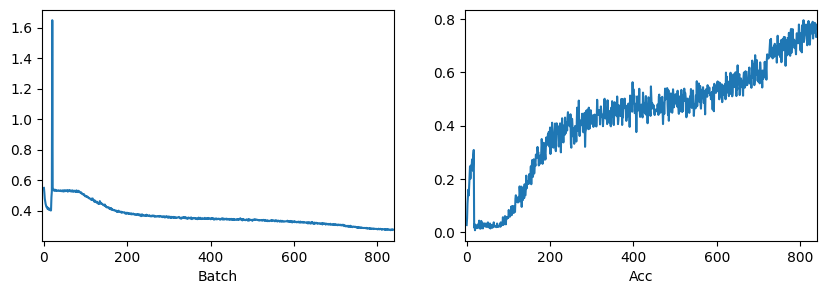

In [6]:
with open(list(model_directory.glob('*/*.log'))[0], 'r') as file:
    log_info = file.read()
loss_lines = [i for i in log_info.split('\n') if ' loss: ' in i]
loss = [float(i.split('  loss: ')[1].split('  loss_kpt:')[0]) for i in loss_lines]
acc = [float(i.split('  acc_pose: ')[1]) for i in loss_lines]

fig, axs = plt.subplots(ncols=2, figsize=(10,3))
axs[0].plot(np.arange(len(loss)), loss)
axs[0].set_xlim([-5, len(loss)])
axs[0].set_xlabel('Batch')
axs[1].set_xlabel('Loss')
axs[1].plot(np.arange(len(acc)), acc)
axs[1].set_xlim([-5, len(acc)])
axs[1].set_xlabel('Batch')
axs[1].set_xlabel('Acc')

### Sample predictions

In [7]:
from mmpose.apis import init_model as init_pose_estimator
from mmpose.apis import inference_topdown

In [8]:
# load a test image
sample_image = '/n/groups/datta/jlove/data/rat_seq/6cam/tim_code/multicamera_labelling_and_training/notebooks/rat_cropped.jpg'
image = Image.open(sample_image)
image_array = np.array(image)
image_array.shape

(512, 512, 3)

In [9]:
device = 'cuda'
cfg_options = dict(model=dict(test_cfg=dict(output_heatmaps=True)))

In [11]:
# build pose estimator
pose_estimator = init_pose_estimator(
    config_loc.as_posix(),
    checkpoint_loc.as_posix(),
    device=device,
    cfg_options=cfg_options
)

Loads checkpoint by local backend from path: /n/groups/datta/tim_sainburg/datasets/scratch/mm_training/rtmpose/rtmpose-m_8xb64-210e_ap10k-256x256_24-08-15-10-58-18/epoch_210.pth


In [12]:
predictions = inference_topdown(pose_estimator, image_array)

/n/groups/datta/tim_sainburg/conda_envs/mmdeploy/lib/python3.10/site-packages/mmpose/models/heads/coord_cls_heads/rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


### Plot prediction confidence

In [13]:
keypoint_estimates = predictions[0].pred_instances.keypoints[0]
kpt_names = np.array(list(pose_estimator.dataset_meta['keypoint_id2name'].values()))
kpt_confidences = predictions[0].pred_instances.keypoint_scores[0]

Text(0.5, 0, 'Confidence')

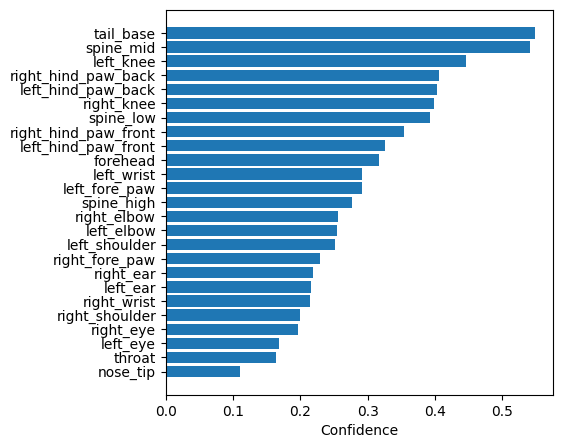

In [14]:
m = np.argsort(kpt_confidences)
fig, ax = plt.subplots(figsize=(5,5))
ax.barh(kpt_names[m], kpt_confidences[m])
ax.set_xlabel('Confidence')

### Visualize predictions

In [15]:
#from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

In [16]:
# init visualizer
pose_estimator.cfg.visualizer.radius = 3
pose_estimator.cfg.visualizer.line_width = 1
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_pose_estimator
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

/n/groups/datta/tim_sainburg/conda_envs/mmdeploy/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [17]:
pose_estimator.dataset_meta.keys()

dict_keys(['dataset_name', 'num_keypoints', 'keypoint_id2name', 'keypoint_name2id', 'upper_body_ids', 'lower_body_ids', 'flip_indices', 'flip_pairs', 'keypoint_colors', 'num_skeleton_links', 'skeleton_links', 'skeleton_link_colors', 'dataset_keypoint_weights', 'sigmas', 'CLASSES'])

In [18]:
# predict keypoints
pose_results = inference_topdown(pose_estimator, image_array)
data_samples = merge_data_samples(pose_results)

/n/groups/datta/tim_sainburg/conda_envs/mmdeploy/lib/python3.10/site-packages/mmpose/models/heads/coord_cls_heads/rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


In [19]:
vis_result = visualizer.add_datasample(
    'result',
    image_array,
    data_sample=data_samples,
    draw_gt=False,
    draw_heatmap=True,
    draw_bbox=True,
    show=False,
    wait_time=0,
    out_file=None,
    kpt_thr=0.3)

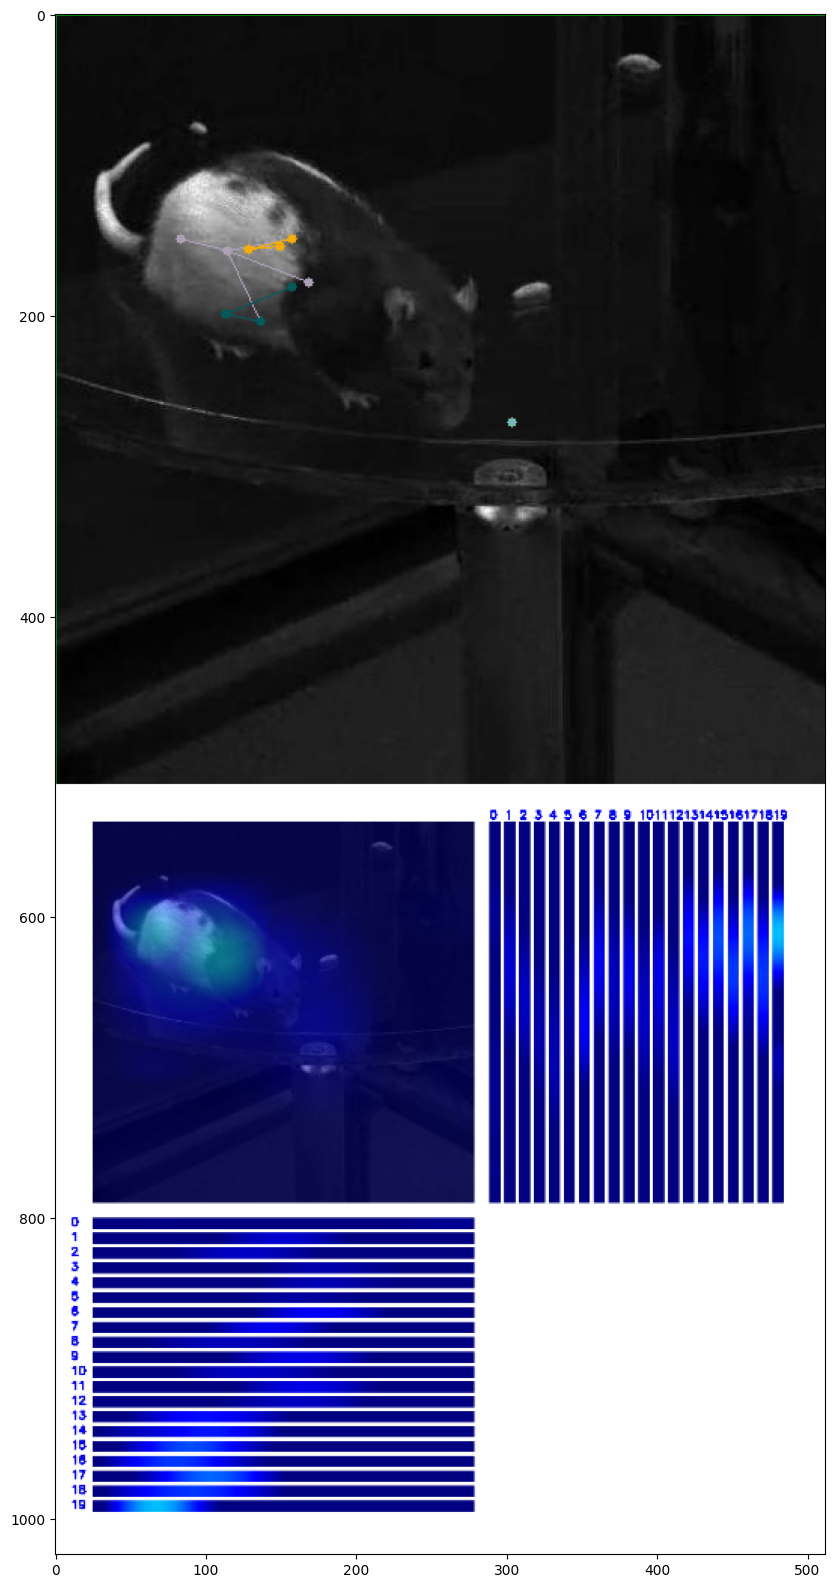

In [20]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(vis_result)

In [21]:
keypoints = [val for key, val in pose_estimator.dataset_meta['keypoint_id2name'].items()]

In [ ]:
def zero_one_norm(x):
    x[x<0] = 0
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=7, figsize=(8,16))

for kni, keypoint_name in enumerate(keypoints):
    ax = axs.flatten()[kni]
    ax.matshow(image_array[::4, ::4,:], cmap = 'Greys_r', extent=[0,1,0,1])
    prediction_hm = predictions[0]._pred_heatmaps.heatmaps[kni].cpu().numpy()
    ax.matshow(prediction_hm, cmap = 'turbo', alpha=zero_one_norm(prediction_hm), extent=[0,1,0,1])
    ax.set_title(keypoint_name)
    ax.axis('off')
    #break
plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.25)
